In [1]:
import psycopg2 as pg
import geopandas as gpd
import csv
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import io
import shapefile
from shapely.geometry import shape
import osr
import folium
from folium.plugins import HeatMap
import copy
import random

host = '130.207.211.78'
dbname = 'nij'
password = 'ElbacMedyov3'

con = pg.connect(host=host, database=dbname, password=password, user='postgres')

In [2]:
query = """SELECT gid, category, call_group, final_case, case_desc, occ_date, census_tra, ST_Transform(geom, 4326) as geom FROM crimes
"""
#print("hey")
fulldf = gpd.read_postgis(query, con, geom_col='geom')
#print("yo")

In [4]:
calls = []
cases = []
descs = []
for x in fulldf['call_group']:
    if x not in calls:
        calls.append(x)
for x in fulldf['category']:
    if x not in cases:
        cases.append(x)
for x in fulldf['case_desc']:
    if x not in descs:
        descs.append(x)
print(calls)
print(cases)
print(descs)

['DISORDER', 'NON CRIMINAL/ADMIN', 'PERSON CRIME', 'PROPERTY CRIME', 'TRAFFIC', 'SUSPICIOUS', None]
['OTHER', 'MOTOR VEHICLE THEFT', 'BURGLARY', 'STREET CRIMES', None]
['UNWANTED PERSON', 'SCHOOL INCIDENT - PRIORITY', 'UNWANTED PERSON - PRIORITY', 'UNWANTED PERSON - WITH WEAPON *H', 'DETOX TRANSPORT', 'SCHOOL INCIDENT - WITH WEAPON *H', 'THREAT - COLD', 'SUBJECT STOP - SDC', 'ASSIST - CITIZEN OR AGENCY', 'TRIMET INCIDENT - COLD', 'TRIMET INCIDENT - PRIORITY', 'TRIMET INCIDENT - WITH WEAPON *H', 'ILLEGAL DUMPING - COLD', 'ILLEGAL DUMPING - PRIORITY', 'CIVIL - CIVIL PROBLEM', 'CIVIL - EVICTION', 'FLAGDOWN', 'FOLLOW-UP', 'DELIVER MESSAGE', 'PROPERTY LOST, FOUND, RECOVERED', 'ASSISTANCE - FIRE / EMS NEED POLICE *H', 'RIVER - MARINE INCIDENT', 'CIVIL - SERVE PAPERS', 'CIVIL - STANDBY', 'TRANSPORT', 'WARRANT', 'WARRANT - WALK-IN / COUNTER', 'WELFARE CHECK - COLD', 'PERSON CONTACT (86)', 'WELFARE CHECK - PRIORITY', 'ASSAULT - COLD', 'BOMB - DEVICE DISCOVERED (33B) *H', 'ROBBERY - COLD', 'SHOO

In [6]:
tracts = ZipFile('res/tl_2015_41_bg.zip')
filenames = [y for y in sorted(tracts.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
dbf, prj, shp, shx = [io.BytesIO(tracts.read(filename)) for filename in filenames]

r = shapefile.Reader(shp=shp, shx=shx, dbf=dbf)

attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]  
for row in r.shapeRecords():  
    geometry.append(shape(row.shape.__geo_interface__))  
    attributes.append(dict(zip(field_names, row.record)))  

proj4_string = osr.SpatialReference(prj.read().decode('UTF-8')).ExportToProj4()
print(proj4_string)

tragdf = gpd.GeoDataFrame(data = attributes, geometry = geometry, crs = proj4_string)

#print(tragdf)

+proj=longlat +ellps=GRS80 +no_defs 


In [11]:
pcrimes = fulldf[fulldf.call_group=='PERSON CRIME']
#pcrimes = pcrimes[pcrimes.geometry.intersects(bound.geometry[0])]
#pcrimes = pcrimes[pcrimes['gid']%10 == 1]
#pcrimes


pop = [0]*len(tragdf.geometry)
with open("res/portlandpop.csv", "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        for j, t in enumerate(tragdf.GEOID):
            if int(t) == int(row['GEO.id2']):
                pop[j] += int(row['HD01_VD01'])
                break
tragdf['POP'] = np.asarray(pop)

#empto = 
crimes = {}
for key in calls:
    if not key == None:
        crimes[key] = [0]*len(tragdf)
#tragdf['PCRIMES'] = count
#tragdf['PCRIMESP'] = count
for i, g in enumerate(fulldf[fulldf['gid']%20 == 1].census_tra):
    for j, t in enumerate(tragdf.TRACTCE):
        if int(t) == int(g):
            if fulldf['call_group'][i] in crimes:
                crimes[fulldf['call_group'][i]][j] += 1
            break

crimep = copy.deepcopy(crimes)
for key in crimep:
    for i, c in enumerate(crimep[key]):
        if pop[i] > 0:
            crimep[key][i] = c/pop[i]
        #else:
        #    countp[i] = 0
    tragdf[key] = np.asarray(crimes[key])
    tragdf[key+" P"] = np.asarray(crimep[key])


In [16]:
bound = gpd.read_postgis("SELECT ST_Transform(geom, 4326) as geom FROM boundaries", con, geom_col='geom')
trago = tragdf[tragdf.geometry.intersects(bound.geometry[0])]
trago = trago[trago['POP'] > 0]
#print(trago)
#print(trago.head())

#trago.plot()
#plt.show()

In [18]:
m = folium.Map(location=[45.55, -122.6], zoom_start=11, 
               tiles='Stamen Toner')
geo_str = (trago).to_json()
m.choropleth(geo_str=geo_str,
             data=trago,columns=['GEOID','PERSON CRIME'],
             key_on='feature.properties.GEOID',
             fill_color="PuBuGn",
             fill_opacity=0.8, line_opacity=0.8,
             legend_name='area')
m

In [22]:
points = []
data = fulldf[fulldf.category == 'MOTOR VEHICLE THEFT']
#data = data[data['gid']%10 == 1]
# Random Variation so we can see when multiple crimes happen in the exact same spot
rv = 1e-6
for i, g in enumerate(data.geom):
    points.append((g.y + random.randint(-100, 100)*rv, g.x + random.randint(-100, 100)*rv, 1))
    #print(g.y)

In [23]:
viridis = ["#000004","#010005","#010106","#010108","#02010a","#02020c","#02020e","#030210","#040312","#040314","#050417","#060419","#07051b","#08051d","#09061f","#0a0722","#0b0724","#0c0826","#0d0829","#0e092b","#10092d","#110a30","#120a32","#140b34","#150b37","#160b39","#180c3c","#190c3e","#1b0c41","#1c0c43","#1e0c45","#1f0c48","#210c4a","#230c4c","#240c4f","#260c51","#280b53","#290b55","#2b0b57","#2d0b59","#2f0a5b","#310a5c","#320a5e","#340a5f","#360961","#380962","#390963","#3b0964","#3d0965","#3e0966","#400a67","#420a68","#440a68","#450a69","#470b6a","#490b6a","#4a0c6b","#4c0c6b","#4d0d6c","#4f0d6c","#510e6c","#520e6d","#540f6d","#550f6d","#57106e","#59106e","#5a116e","#5c126e","#5d126e","#5f136e","#61136e","#62146e","#64156e","#65156e","#67166e","#69166e","#6a176e","#6c186e","#6d186e","#6f196e","#71196e","#721a6e","#741a6e","#751b6e","#771c6d","#781c6d","#7a1d6d","#7c1d6d","#7d1e6d","#7f1e6c","#801f6c","#82206c","#84206b","#85216b","#87216b","#88226a","#8a226a","#8c2369","#8d2369","#8f2469","#902568","#922568","#932667","#952667","#972766","#982766","#9a2865","#9b2964","#9d2964","#9f2a63","#a02a63","#a22b62","#a32c61","#a52c60","#a62d60","#a82e5f","#a92e5e","#ab2f5e","#ad305d","#ae305c","#b0315b","#b1325a","#b3325a","#b43359","#b63458","#b73557","#b93556","#ba3655","#bc3754","#bd3853","#bf3952","#c03a51","#c13a50","#c33b4f","#c43c4e","#c63d4d","#c73e4c","#c83f4b","#ca404a","#cb4149","#cc4248","#ce4347","#cf4446","#d04545","#d24644","#d34743","#d44842","#d54a41","#d74b3f","#d84c3e","#d94d3d","#da4e3c","#db503b","#dd513a","#de5238","#df5337","#e05536","#e15635","#e25734","#e35933","#e45a31","#e55c30","#e65d2f","#e75e2e","#e8602d","#e9612b","#ea632a","#eb6429","#eb6628","#ec6726","#ed6925","#ee6a24","#ef6c23","#ef6e21","#f06f20","#f1711f","#f1731d","#f2741c","#f3761b","#f37819","#f47918","#f57b17","#f57d15","#f67e14","#f68013","#f78212","#f78410","#f8850f","#f8870e","#f8890c","#f98b0b","#f98c0a","#f98e09","#fa9008","#fa9207","#fa9407","#fb9606","#fb9706","#fb9906","#fb9b06","#fb9d07","#fc9f07","#fca108","#fca309","#fca50a","#fca60c","#fca80d","#fcaa0f","#fcac11","#fcae12","#fcb014","#fcb216","#fcb418","#fbb61a","#fbb81d","#fbba1f","#fbbc21","#fbbe23","#fac026","#fac228","#fac42a","#fac62d","#f9c72f","#f9c932","#f9cb35","#f8cd37","#f8cf3a","#f7d13d","#f7d340","#f6d543","#f6d746","#f5d949","#f5db4c","#f4dd4f","#f4df53","#f4e156","#f3e35a","#f3e55d","#f2e661","#f2e865","#f2ea69","#f1ec6d","#f1ed71","#f1ef75","#f1f179","#f2f27d","#f2f482","#f3f586","#f3f68a","#f4f88e","#f5f992","#f6fa96","#f8fb9a","#f9fc9d","#fafda1","#fcffa4"]
l = len(viridis)
grad = {}
for x in range(0, l, 20):
    grad[x/l] = viridis[x]
#print(grad)

In [28]:
#print(points)


m = folium.Map(zoom_start=11, tiles='Stamen Toner')

bnds = bound.geom[0].bounds
bnds = [(bnds[3], bnds[2]), (bnds[1], bnds[0])]
m.fit_bounds(bnds)

m.add_child(HeatMap(points, radius = 15, blur = 15))

m

/home/nknauf/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


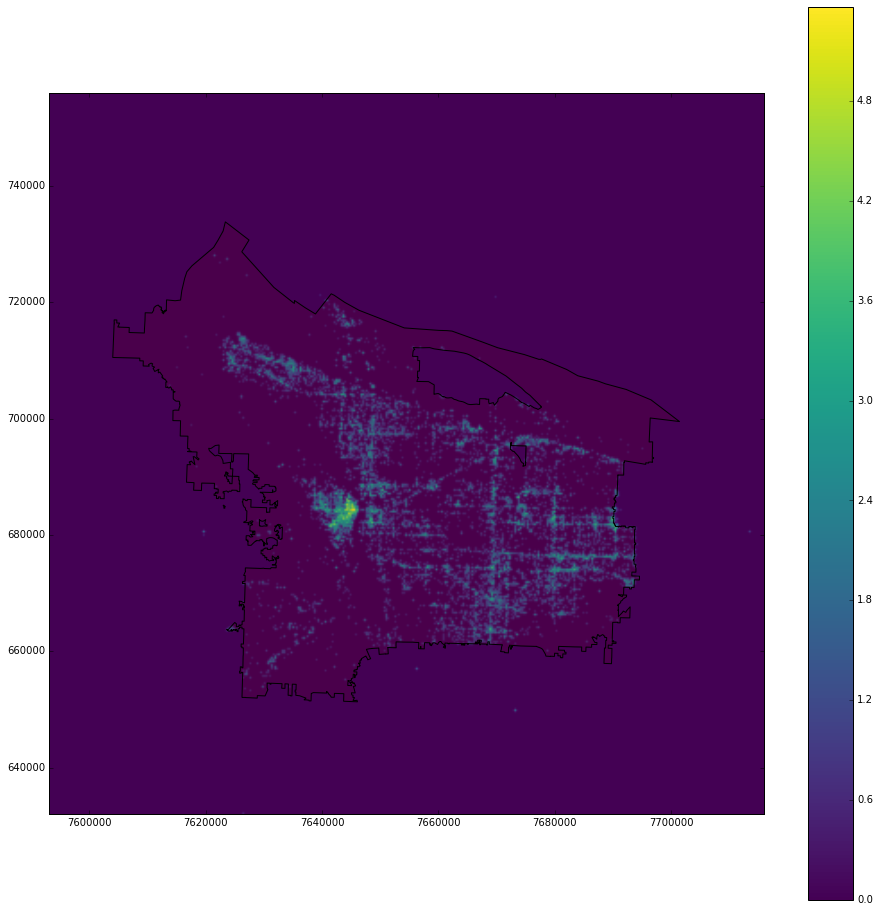

In [16]:
#plt.figure(figsize=(20, 20))
bound = gpd.read_postgis("SELECT * FROM boundaries", con, geom_col='geom')
bound[bound.name=='police_merged'].plot(alpha=0.1, figsize=(16, 16), fill_color='None')
heatmap(pcrimes, bins=(400, 400), smoothing=0.5, cmap='viridis')
plt.show()

/home/nknauf/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


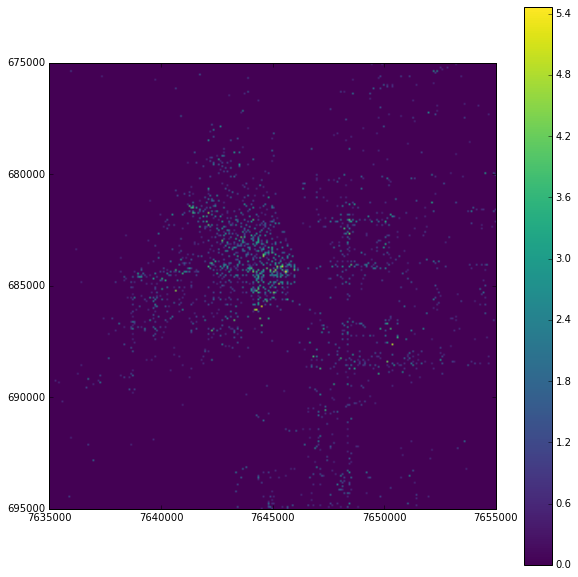

In [8]:
plt.figure(figsize=(10, 10))
plt.ylim((675000, 695000))
plt.xlim((7635000,7655000))
heatmap(pcrimes, bins=(1600, 1600), smoothing=0, cmap='viridis')
plt.show()

In [6]:
import numpy as np
from scipy import ndimage

def heatmap(d, bins=(100,100), smoothing=1.3, cmap='viridis'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

/home/nknauf/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


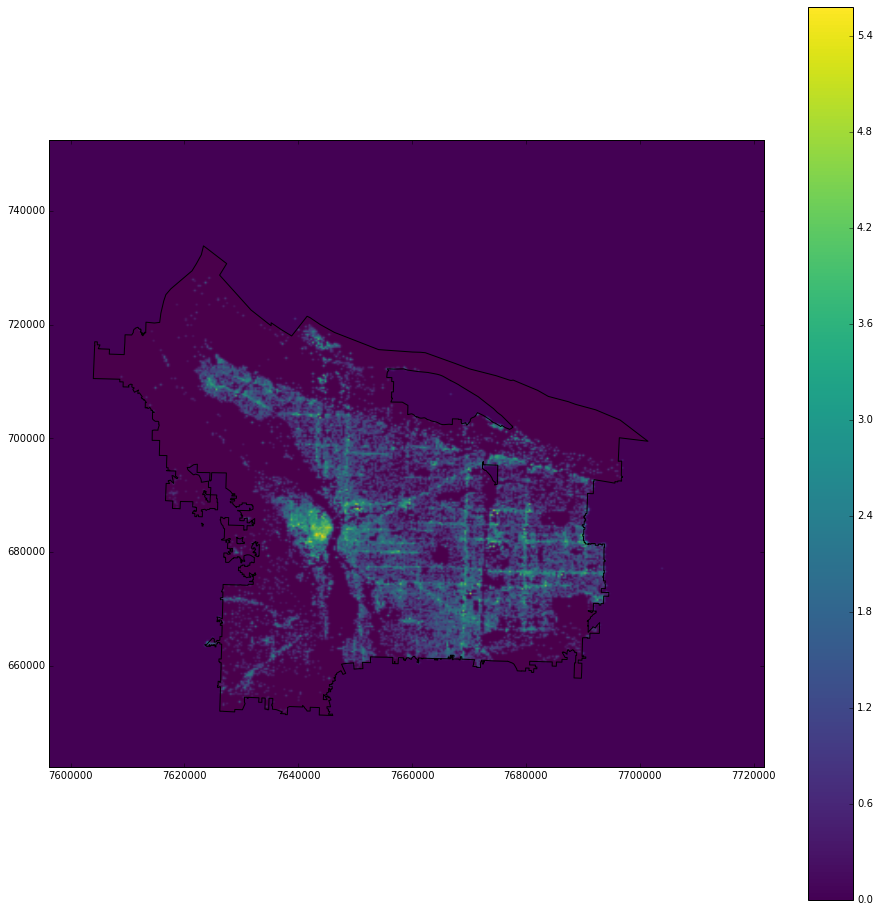

In [10]:
propcrime = fulldf[fulldf.call_group=='PROPERTY CRIME']
bound[bound.name=='police_merged'].plot(alpha=0.1, figsize=(16, 16))
heatmap(propcrime, bins=(400, 400), smoothing=0.5, cmap='viridis')
plt.show()

/home/nknauf/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


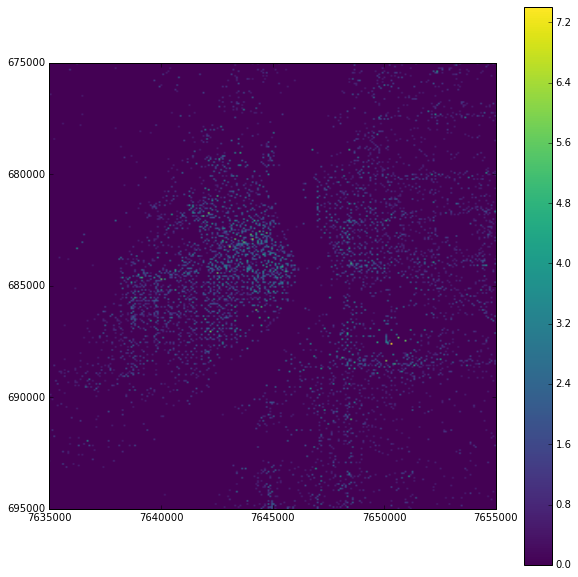

In [11]:
plt.figure(figsize=(10, 10))
plt.ylim((675000, 695000))
plt.xlim((7635000,7655000))
heatmap(propcrime, bins=(1600, 1600), smoothing=0, cmap='viridis')
plt.show()